<a href="https://colab.research.google.com/github/jan-kreischer/UZH_ML4NLP/blob/main/Project-03/ex03_cnn_jan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Language Identification (Reloaded and Convoluted)
## 1. Setup
### 1.1 Dependencies

In [ ]:
!pip install demoji

In [ ]:
!pip install googletrans==4.0.0rc1


### 1.2 Imports

In [115]:
# Misc
import csv
import re
from io import StringIO
import requests
import string
import numpy as np
import matplotlib.pyplot as plt  
import demoji

# Pandas
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Back Translation
from googletrans import Translator
translator = Translator()

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, AveragePooling1D, Dense, Dropout, Activation, Embedding
from keras import backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Torch
import torch

# Sklearn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

### 1.2 Environment
We check if the environment we are using is properly setup, such that we are using GPU for training our models.

In [7]:
# Check if device supports CUDA interface
CUDA = torch.cuda.is_available()
# Make program run on gpu (cuda:0) if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu:0')
torch.cuda.set_device(device)
print('Using device:', device)

Using device: cuda:0


In [8]:
# Check and print information about available GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov  8 13:15:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-80eb3a39-123a-322e-a52d-cbe57ce77608)


In [10]:
# Check Memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### 1.4 Constants

In [56]:
TARGET_COLUMN = 'label'
TWEET_COLUMN = 'tweet'
SAMPLE_THRESHOLD = 100
EMBEDDING_DIM = 50
MAX_SEQ_LEN = 80

## 2. Data Acquisition

In [12]:
url_train = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

In [13]:
def load_dataset(url):
  r = requests.get(url)
  data = r.content.decode('utf8')
  df = pd.read_csv(StringIO(data), sep='\t')
  df.columns = ['tweet', 'label']
  return df

In [14]:
df_train = load_dataset(url_train)
df_test = load_dataset(url_test)

In [16]:
# Merge into one dataset for the pre-processing
# We merge the training and the test data into one dataframe in order
# to ensure that training and test data comes from the same distribution
# We saw that some languages/ labels do not appear in the training data
# while appearing in the test data and the other way around
# This is not desirable
# Before starting to train we randomly shuffle and split into train and test data
dataset = pd.concat([df_train, df_test], axis=0) 

In [17]:
print("The length of the combined dataset is {0} training samples + {1} test samples = {2} samples".format(len(df_train), len(df_test), len(dataset)))

The length of the combined dataset is 52675 training samples + 13279 test samples = 65954 samples


In [18]:
dataset = dataset.sample(frac=1).reset_index(drop=True) # Randomly shuffle the data

In [19]:
dataset.head(10) # Show some sample tweets

,tweet,label
0,@minaahmorv thanks mbak,en
1,腹減った♪,ja
2,@Rach_Louu got anything in mind? X,en
3,THREE #MTVHottest Little Mix,en
4,#NowPlaying If I Were A Boy by Beyoncé,en
5,告白日和ギリギリクリアできた…！www http://t.co/5zc61NuWuZ,ja
6,"@sharonclau ujian jam 11 sher, tp jam 8 mau ad...",id
7,---&gt; http://t.co/RJjLnVaUKI,und
8,s #MTVHottest One Direction,en
9,When we smoke we gotta use them incense baby,en


## 3. Data Exploration

In [20]:
def data_exploration(df):
  n_labels = len(np.unique(df["label"]))
  df = df.sort_values('label')
  print("Dataset contains the columns: {}".format(list(df.keys())))
  print("with a total of {} observations".format(len(df)))
  print("and {} different possible labels.".format(n_labels))
  print("The unique labels are {}".format(df["label"].unique()))
  plt.figure(figsize=(15, 3))
  plt.hist(df["label"], bins=n_labels)
  plt.xticks(rotation=90)
  plt.yscale("log")
  plt.xlabel("Language")
  plt.ylabel("#Occurences")
  plt.show()

In [21]:
# This function checks which lanugages occur in the full dataset less than 'SAMPLE_THRESHOLD' times.
# These languages are then returned as the list of underrepresented languages
def get_underrepresented_languages(df, target_column, sample_threshold):
    df = df.groupby(target_column).size().to_frame().reset_index(drop=False).rename(columns={0: 'occurences'})
    underrepresented_languages = list(df[df['occurences'] < SAMPLE_THRESHOLD][target_column])
    return underrepresented_languages

In [22]:
def print_number_of_underrepresented_languages(df, target_column, sample_threshold):
  underrepresented_languages = get_underrepresented_languages(df, target_column, sample_threshold)
  print("There are {} languages in this data set with less then {} samples.".format(len(underrepresented_languages), sample_threshold))

Dataset contains the columns: ['tweet', 'label']
with a total of 65954 observations
and 78 different possible labels.
The unique labels are ['ar' 'ar_LATN' 'az' 'bg' 'bn' 'bs' 'ca' 'cs' 'cy' 'da' 'de' 'dv' 'el'
 'en' 'es' 'et' 'eu' 'fa' 'fi' 'fr' 'gl' 'ha' 'he' 'hi' 'hi-Latn' 'hr'
 'ht' 'hu' 'hy' 'id' 'is' 'it' 'ja' 'ja_LATN' 'jv' 'km' 'ko' 'ko_LATN'
 'la' 'lv' 'mk' 'mn' 'mr' 'ms' 'ne' 'nl' 'no' 'pl' 'ps' 'ps_LATN' 'pt'
 'ro' 'ru' 'si' 'sk' 'sl' 'sq' 'sr' 'su' 'sv' 'sw' 'ta' 'ta_LATN' 'th'
 'tl' 'tn' 'tr' 'uk' 'und' 'ur' 'ur_LATN' 'vi' 'wo' 'xh' 'yo' 'zh-CN'
 'zh-TW' 'zu']


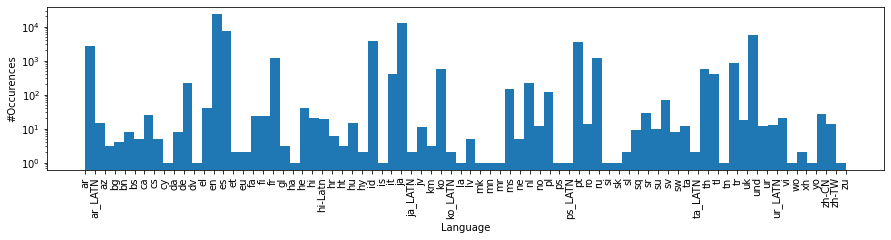

In [23]:
data_exploration(dataset)

In [24]:
print_number_of_underrepresented_languages(dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

There are 50 languages in this data set with less then 20 samples.


In [25]:
# Display all languages and their absolute number off occurences in descending order
language_count=dataset[TARGET_COLUMN].value_counts().reset_index()
language_count
df = pd.DataFrame(language_count)
df.columns = ['language', 'occurences']
df

,language,occurences
0,en,23266
1,ja,12899
2,es,7406
3,und,5766
4,id,3823
5,pt,3577
6,ar,2728
7,ru,1221
8,fr,1170
9,tr,843


## 4. Text Cleaning

This is generally a good idea as many text classification tools rely on counting the occurrences of words. If both upper and lower case versions of the same word are found in the text then the algorithm will count them as different words even though the meaning is the same. Of course this does mean that where the capitalised versions of a word exists, that does have a different meaning. For example the company Apple vs the fruit apple. This could result in poorer performance for some data sets. This is one area of NLP where you may try different methods to see how they affect the overall performance of the model. We decided to transform our corpus into lowercase, since the case wont have
a big influence on the language classification performance

In [26]:
def remove_all_emojis(text):
  dem = demoji.findall(text)
  for item in dem.keys():
    text = text.replace(item, '')
  return text

In [27]:
def clean_data(df, column):
    df = df.copy(deep=True) # Make deep copy of tweets
    df[column] = df[column].str.lower() # Transform into all lowercase
    
    patterns = []
    retweet_pattern = '^RT'
    patterns.append(retweet_pattern)
    xml_pattern = '&\S+;'
    patterns.append(xml_pattern)
    hashtag_pattern = '#[A-Za-z0-9_]+'
    patterns.append(hashtag_pattern)
    twitter_mention_pattern = '@[A-Za-z0-9_]+'
    patterns.append(twitter_mention_pattern)
    http_pattern = 'http\S+'
    patterns.append(http_pattern)
    www_pattern = 'www\S+'
    patterns.append(www_pattern)
    tab_pattern = '\t'
    patterns.append(tab_pattern)
    punctuation_pattern = '[!"#$%&\\()*+,-./:;<=>?@\[\]^_`\'{}~]+'
    patterns.append(punctuation_pattern)
    numeric_pattern = '[0-9]+'
    patterns.append(numeric_pattern)
    regex = "|".join(patterns)

    #df[column] = df[column].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem)) 
    df[column] = df[column].apply(lambda elem: re.sub(r"{}".format(regex), "", elem))
    df[column] = df[column].apply(remove_all_emojis)
    
    return df

In [28]:
cleaned_dataset = clean_data(dataset, TWEET_COLUMN)

## 5.Data Augmentation
We consider languages which have less then 100 sample tweets in the dataset as infrequent. You can either remove these infrequent languages or use augmentation or upsampling techniques to increase the language frequency.
We decided to use back translation in order to keep infrequent languages but increase their frequency.


In [32]:
def back_translation(df,target_languages=['en']):
  translated_data = pd.DataFrame(columns={TWEET_COLUMN, TARGET_COLUMN})
  for target_language in target_languages:
    for index, row in df.iterrows():
      try:
        tweet = row[TWEET_COLUMN]
        source_language = row[TARGET_COLUMN]
        translated_data=translated_data.append({'tweet': translator.translate(translator.translate(tweet, dest=target_language).text, dest=source_language).text, 'label': source_language}, ignore_index=True)
      except Exception as e:
        pass
  return translated_data

In [33]:
print_number_of_underrepresented_languages(cleaned_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

There are 60 languages in this data set with less then 100 samples.


In [37]:
# Print the list of underrepresented languages
underrepresented_languages = get_underrepresented_languages(cleaned_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)
print(underrepresented_languages)

['ar_LATN', 'az', 'bg', 'bn', 'bs', 'ca', 'cs', 'cy', 'da', 'dv', 'el', 'et', 'eu', 'fa', 'fi', 'gl', 'ha', 'he', 'hi', 'hi-Latn', 'hr', 'ht', 'hu', 'hy', 'is', 'ja_LATN', 'jv', 'km', 'ko_LATN', 'la', 'lv', 'mk', 'mn', 'mr', 'ne', 'no', 'ps', 'ps_LATN', 'ro', 'si', 'sk', 'sl', 'sq', 'sr', 'su', 'sv', 'sw', 'ta', 'ta_LATN', 'tn', 'uk', 'ur', 'ur_LATN', 'vi', 'wo', 'xh', 'yo', 'zh-CN', 'zh-TW', 'zu']


In [43]:
# Increasing the number of rare languages by backtranslation
upsampled_dataset = cleaned_dataset.copy()

for l in underrepresented_languages:
  underrepresented_language = upsampled_dataset[upsampled_dataset[TARGET_COLUMN]==l]
  upsampled_dataset.drop(upsampled_dataset[upsampled_dataset[TARGET_COLUMN]==l].index, inplace = True, axis=0)
  len_first = len(underrepresented_language)

  if not l.endswith('latn'): # Only run the upsamling for non latn languages
    underrepresented_language = pd.concat([underrepresented_language, back_translation(underrepresented_language)], axis=0) # run back translation
  
  len_second = len(underrepresented_language)
  if(len_second < SAMPLE_THRESHOLD):
    underrepresented_language = resample(underrepresented_language, n_samples=SAMPLE_THRESHOLD)
  len_third = len(underrepresented_language)
  
  print("({0}): #{1}=>back_translation=>#{2}=>resampling=>#{3}".format(l, len_first, len_second, len_third))
  upsampled_dataset = pd.concat([upsampled_dataset, underrepresented_language], axis=0)

(ar_LATN): #15=>back_translation=>#30=>resampling=>#100
(az): #3=>back_translation=>#6=>resampling=>#100
(bg): #4=>back_translation=>#8=>resampling=>#100
(bn): #8=>back_translation=>#16=>resampling=>#100
(bs): #5=>back_translation=>#10=>resampling=>#100
(ca): #25=>back_translation=>#50=>resampling=>#100
(cs): #5=>back_translation=>#10=>resampling=>#100
(cy): #1=>back_translation=>#2=>resampling=>#100
(da): #8=>back_translation=>#16=>resampling=>#100
(dv): #1=>back_translation=>#1=>resampling=>#100
(el): #39=>back_translation=>#78=>resampling=>#100
(et): #2=>back_translation=>#4=>resampling=>#100
(eu): #2=>back_translation=>#4=>resampling=>#100
(fa): #23=>back_translation=>#46=>resampling=>#100
(fi): #23=>back_translation=>#46=>resampling=>#100
(gl): #3=>back_translation=>#6=>resampling=>#100
(ha): #1=>back_translation=>#2=>resampling=>#100
(he): #41=>back_translation=>#82=>resampling=>#100
(hi): #20=>back_translation=>#40=>resampling=>#100
(hi-Latn): #19=>back_translation=>#19=>resampl

In [45]:
upsampled_dataset.reset_index(drop=True);

In [40]:
upsampled_dataset.to_pickle('./dataset.pkl') # Save dataset as compact pkl file
upsampled_dataset.to_csv('./dataset.csv', header=True, index=False) # Save dataset as easily accessible csv file

In [46]:
# Check that no underrepresented languages exists anymore in the dataset
# The list of underrepresented languages needs to be empty now
print_number_of_underrepresented_languages(upsampled_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

There are 0 languages in this data set with less then 100 samples.


In [47]:
print("The length of the upsampled dataset is {}.".format(len(upsampled_dataset)))

The length of the upsampled dataset is 71404.


## 6. Tokenize Data

In [49]:
# Tokenize on the character level
tokenizer = Tokenizer(num_words=None, char_level=True, oov_token='OOV')
tokenizer.fit_on_texts(dataset[TWEET_COLUMN].tolist())

In [50]:
vectorized_data = tokenizer.texts_to_sequences(dataset[TWEET_COLUMN])

In [51]:
padding_length=80
padded_data = pad_sequences(vectorized_data, maxlen=padding_length, padding='post')

In [52]:
label2index = {label:index for index, label in enumerate(dataset[TARGET_COLUMN].unique())}
dataset['language_index'] = dataset[TARGET_COLUMN].apply(lambda x: label2index[x])
y_indices = dataset['language_index'].values
y_indices = [x for x in y_indices]

In [53]:
y_categorical = to_categorical(y_indices)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(padded_data, y_categorical, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [57]:
vocab_size = len(tokenizer.word_index)
embedding_dim = 50

## 7. Modelling

In [76]:
def model_classification_report(model, X_train, y_train):
  y_pred = model.predict(X_train, verbose=1)
  print(classification_report(y_train.argmax(axis=1), y_pred.argmax(axis=1)))

In [58]:
def plot_history(history):
  plt.figure(figsize=(12,6))
  plt.subplot(1, 2, 1)
  plt.title("Accuracy")
  plt.plot(history.history['accuracy'], color="b", label="accuracy")
  plt.plot(history.history['val_accuracy'], color="r", label="val_accuracy")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower left")
  #plt.ylim([0,1])
  #plt.title("Comparison of accuracy and validation accuracy")
  plt.subplot(1, 2, 2)
  plt.title("Loss")
  plt.plot(history.history['loss'], color="b", label="loss")
  plt.plot(history.history['val_loss'],  color="r", label="val_loss")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")
  #plt.ylim([0,1])
  plt.show

In [59]:
def train_model(X_train, y_train, X_val, y_val, params):
  es = EarlyStopping(monitor='val_loss', mode='auto', verbose=params['verbose'], patience=params["patience"])

  # define model
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_length=padding_length))
  model.add(Dropout(params['dropout']))
  model.add(Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], strides=params['strides'], padding='valid', activation='relu'))
  model.add(params['pooling'])
  model.add(Dense(params['hidden_dims']))
  model.add(Dropout(params['dropout']))
  model.add(Activation('relu'))
  #model.add(Dense(len(label2index)))
  model.add(Dense(len(label2index)))
  model.add(Activation('softmax'))
  model.compile(optimizer=params['optimizer'], loss="categorical_crossentropy", metrics=['accuracy'])
  K.set_value(model.optimizer.learning_rate, params['learning_rate'])

  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=params['batch_size'], epochs=params["epochs"], verbose=params["verbose"],  callbacks = [es]) 

  return history, model

### Model 01

In [90]:
params_1 = {
    'dropout': 0.5,
    'filters': 128,
    'kernel_size': 3,
    'strides': 1,
    'pooling': GlobalMaxPooling1D(),  # MaxPool1D(), AveragePooling1D(), 
    'hidden_dims': 128,
    'learning_rate': 0.01,
    'batch_size': 64,
    'optimizer': 'adam',
    'epochs': 100,
    'verbose': 1,
    'patience': 20
}

In [91]:
history_1, model_1 = train_model(X_train, y_train, X_val, y_val, params_1)

Epoch 1/100
742/742 [==============================] - 4s 5ms/step - loss: 1.0177 - accuracy: 0.7172 - val_loss: 0.6440 - val_accuracy: 0.8190
Epoch 2/100
742/742 [==============================] - 3s 4ms/step - loss: 0.7934 - accuracy: 0.7836 - val_loss: 0.5892 - val_accuracy: 0.8478
Epoch 3/100
742/742 [==============================] - 3s 4ms/step - loss: 0.7497 - accuracy: 0.7976 - val_loss: 0.6177 - val_accuracy: 0.8469
Epoch 4/100
742/742 [==============================] - 3s 4ms/step - loss: 0.7363 - accuracy: 0.8024 - val_loss: 0.5736 - val_accuracy: 0.8495
Epoch 5/100
742/742 [==============================] - 3s 4ms/step - loss: 0.7244 - accuracy: 0.8050 - val_loss: 0.5906 - val_accuracy: 0.8475
Epoch 6/100
742/742 [==============================] - 3s 4ms/step - loss: 0.7301 - accuracy: 0.8080 - val_loss: 0.6301 - val_accuracy: 0.8537
Epoch 7/100
742/742 [==============================] - 3s 4ms/step - loss: 0.7100 - accuracy: 0.8111 - val_loss: 0.6331 - val_accuracy: 0.8556

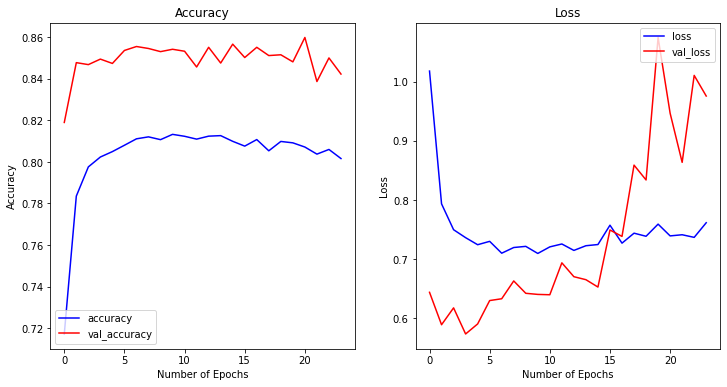

In [92]:
plot_history(history_1)

In [94]:
model_classification_report(model_1, X_test, y_test)

413/413 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      4652
           1       0.99      0.98      0.99      2590
           2       0.78      0.70      0.74       774
           3       0.73      0.54      0.62      1147
           4       0.80      0.83      0.82      1453
           5       0.93      0.65      0.77       715
           6       0.99      0.99      0.99       551
           7       0.97      0.98      0.98       250
           8       0.93      0.68      0.79       165
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00        72
          11       0.85      0.49      0.62       237
          12       0.00      0.00      0.00        18
          13       0.00      0.00      0.00        43
          14       0.98      0.94      0.96       110
          15       0.00      0.00      0.00         5
          16       0.55   

### Model 02

In [99]:
params_2 = {
    'dropout': 0.25,
    'filters': 256,
    'kernel_size': 7,
    'strides': 1,
    'pooling': GlobalMaxPooling1D(), 
    'hidden_dims': 128,
    'learning_rate': 0.01,
    'batch_size': 128,
    'optimizer': 'SGD',
    'epochs': 100,
    'verbose': 1,
    'patience': 20
}

In [100]:
history_2, model_2 = train_model(X_train, y_train, X_val, y_val, params_2)

Epoch 1/100
371/371 [==============================] - 2s 5ms/step - loss: 3.1051 - accuracy: 0.3383 - val_loss: 2.2942 - val_accuracy: 0.3489
Epoch 2/100
371/371 [==============================] - 2s 5ms/step - loss: 2.1753 - accuracy: 0.3702 - val_loss: 2.0987 - val_accuracy: 0.3561
Epoch 3/100
371/371 [==============================] - 2s 5ms/step - loss: 2.0640 - accuracy: 0.4192 - val_loss: 2.0135 - val_accuracy: 0.4106
Epoch 4/100
371/371 [==============================] - 2s 5ms/step - loss: 1.9749 - accuracy: 0.4587 - val_loss: 1.9326 - val_accuracy: 0.4169
Epoch 5/100
371/371 [==============================] - 2s 5ms/step - loss: 1.8822 - accuracy: 0.4802 - val_loss: 1.8321 - val_accuracy: 0.4747
Epoch 6/100
371/371 [==============================] - 2s 5ms/step - loss: 1.7975 - accuracy: 0.4974 - val_loss: 1.7477 - val_accuracy: 0.4993
Epoch 7/100
371/371 [==============================] - 2s 5ms/step - loss: 1.7241 - accuracy: 0.5091 - val_loss: 1.6717 - val_accuracy: 0.5141

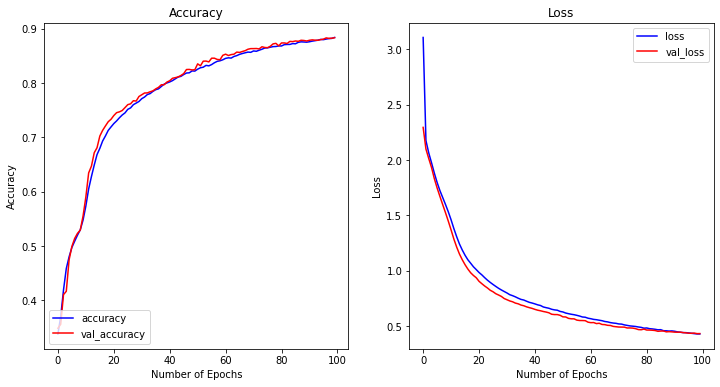

In [101]:
plot_history(history_2)

In [102]:
model_classification_report(model_2, X_train, y_train)

1484/1484 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     16773
           1       0.98      0.99      0.99      9264
           2       0.76      0.91      0.83      2743
           3       0.79      0.61      0.69      4151
           4       0.86      0.96      0.91      5375
           5       0.88      0.81      0.84      2564
           6       0.96      0.99      0.97      1946
           7       0.95      0.97      0.96       872
           8       0.87      0.69      0.77       612
           9       0.00      0.00      0.00        29
          10       0.89      0.08      0.15       310
          11       0.87      0.71      0.78       831
          12       0.00      0.00      0.00        46
          13       0.71      0.09      0.16       161
          14       0.84      0.68      0.75       408
          15       0.00      0.00      0.00        19
          16       0.70 

### Model 3

In [103]:
params_3 = {
    'dropout': 0.25,
    'filters': 512,
    'kernel_size': 3,
    'strides': 2,
    'pooling': GlobalMaxPooling1D(),
    'hidden_dims': 128,
    'learning_rate': 0.01,
    'batch_size': 64,
    'optimizer': 'adam',
    'epochs': 100,
    'verbose': 1,
    'patience': 20
}

In [104]:
history_3, model_3 = train_model(X_train, y_train, X_val, y_val, params_3)

Epoch 1/100
742/742 [==============================] - 4s 5ms/step - loss: 0.8164 - accuracy: 0.7764 - val_loss: 0.6639 - val_accuracy: 0.8194
Epoch 2/100
742/742 [==============================] - 3s 4ms/step - loss: 0.6377 - accuracy: 0.8333 - val_loss: 0.5744 - val_accuracy: 0.8600
Epoch 3/100
742/742 [==============================] - 3s 4ms/step - loss: 0.6064 - accuracy: 0.8401 - val_loss: 0.6110 - val_accuracy: 0.8524
Epoch 4/100
742/742 [==============================] - 3s 4ms/step - loss: 0.5960 - accuracy: 0.8420 - val_loss: 0.5959 - val_accuracy: 0.8588
Epoch 5/100
742/742 [==============================] - 3s 4ms/step - loss: 0.5862 - accuracy: 0.8439 - val_loss: 0.5876 - val_accuracy: 0.8649
Epoch 6/100
742/742 [==============================] - 3s 4ms/step - loss: 0.5848 - accuracy: 0.8437 - val_loss: 0.7114 - val_accuracy: 0.8550
Epoch 7/100
742/742 [==============================] - 3s 4ms/step - loss: 0.5752 - accuracy: 0.8466 - val_loss: 0.7294 - val_accuracy: 0.8637

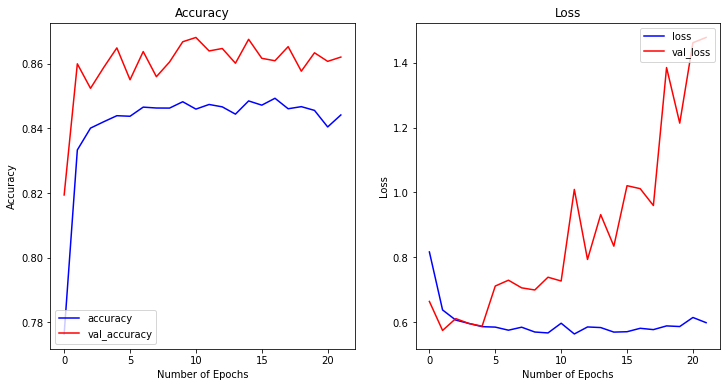

In [105]:
plot_history(history_3)

In [106]:
model_classification_report(model_3, X_train, y_train)

1484/1484 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.82      0.99      0.89     16773
           1       1.00      1.00      1.00      9264
           2       0.74      0.84      0.78      2743
           3       0.88      0.53      0.66      4151
           4       0.87      0.89      0.88      5375
           5       0.94      0.76      0.84      2564
           6       0.98      0.99      0.98      1946
           7       0.99      0.93      0.96       872
           8       0.98      0.75      0.85       612
           9       0.50      0.03      0.06        29
          10       1.00      0.10      0.18       310
          11       0.86      0.65      0.74       831
          12       0.00      0.00      0.00        46
          13       0.59      0.29      0.39       161
          14       1.00      0.99      1.00       408
          15       0.00      0.00      0.00        19
          16       1.00 

### Model 4

In [107]:
params_4 = {
    'dropout': 0.5,
    'filters': 128,
    'kernel_size': 5,
    'strides': 1,
    'pooling': GlobalMaxPooling1D(),  # MaxPool1D(), AveragePooling1D(), 
    'hidden_dims': 256,
    'learning_rate': 0.001,
    'batch_size': 64,
    'optimizer': 'adam',
    'epochs': 100,
    'verbose': 1,
    'patience': 20
}

In [108]:
history_4, model_4 = train_model(X_train, y_train, X_val, y_val, params_4)

Epoch 1/100
742/742 [==============================] - 4s 5ms/step - loss: 1.1970 - accuracy: 0.6716 - val_loss: 0.6459 - val_accuracy: 0.8137
Epoch 2/100
742/742 [==============================] - 3s 4ms/step - loss: 0.6123 - accuracy: 0.8302 - val_loss: 0.4926 - val_accuracy: 0.8579
Epoch 3/100
742/742 [==============================] - 3s 4ms/step - loss: 0.5112 - accuracy: 0.8572 - val_loss: 0.4316 - val_accuracy: 0.8755
Epoch 4/100
742/742 [==============================] - 3s 4ms/step - loss: 0.4601 - accuracy: 0.8711 - val_loss: 0.3896 - val_accuracy: 0.8893
Epoch 5/100
742/742 [==============================] - 3s 4ms/step - loss: 0.4253 - accuracy: 0.8797 - val_loss: 0.3754 - val_accuracy: 0.8950
Epoch 6/100
742/742 [==============================] - 3s 4ms/step - loss: 0.4009 - accuracy: 0.8853 - val_loss: 0.3610 - val_accuracy: 0.8979
Epoch 7/100
742/742 [==============================] - 3s 4ms/step - loss: 0.3815 - accuracy: 0.8883 - val_loss: 0.3524 - val_accuracy: 0.9045

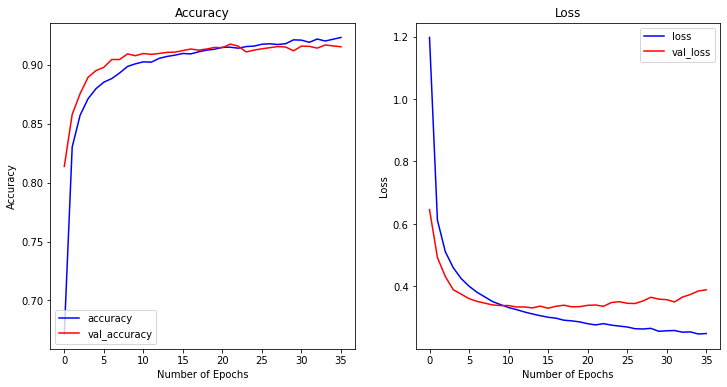

In [109]:
plot_history(history_4)

In [111]:
model_classification_report(model_4, X_train, y_train)

1484/1484 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     16773
           1       1.00      1.00      1.00      9264
           2       0.86      0.93      0.90      2743
           3       0.86      0.74      0.80      4151
           4       0.94      0.97      0.95      5375
           5       0.95      0.93      0.94      2564
           6       0.98      1.00      0.99      1946
           7       0.98      1.00      0.99       872
           8       0.97      0.91      0.94       612
           9       1.00      0.90      0.95        29
          10       0.93      0.83      0.88       310
          11       0.96      0.89      0.92       831
          12       0.90      0.78      0.84        46
          13       0.94      0.76      0.84       161
          14       1.00      1.00      1.00       408
          15       1.00      1.00      1.00        19
          16       1.00 

### Model 5

In [62]:
params_5 = {
    'dropout': 0.25,
    'filters': 128,
    'kernel_size': 5,
    'strides': 1,
    'pooling': GlobalMaxPooling1D(),  # MaxPool1D(), AveragePooling1D(), 
    'hidden_dims': 128,
    'learning_rate': 0.001,
    'batch_size': 128,
    'optimizer': 'adam',
    'epochs': 100,
    'verbose': 1,
    'patience': 20
}

In [63]:
history_5, model_5 = train_model(X_train, y_train, X_val, y_val, params_5)

Epoch 1/100
371/371 [==============================] - 20s 8ms/step - loss: 1.2866 - accuracy: 0.6652 - val_loss: 0.6230 - val_accuracy: 0.8298
Epoch 2/100
371/371 [==============================] - 3s 7ms/step - loss: 0.5464 - accuracy: 0.8527 - val_loss: 0.4553 - val_accuracy: 0.8713
Epoch 3/100
371/371 [==============================] - 3s 7ms/step - loss: 0.4372 - accuracy: 0.8795 - val_loss: 0.4100 - val_accuracy: 0.8846
Epoch 4/100
371/371 [==============================] - 2s 7ms/step - loss: 0.3842 - accuracy: 0.8912 - val_loss: 0.3760 - val_accuracy: 0.8943
Epoch 5/100
371/371 [==============================] - 3s 7ms/step - loss: 0.3479 - accuracy: 0.8993 - val_loss: 0.3584 - val_accuracy: 0.8977
Epoch 6/100
371/371 [==============================] - 2s 7ms/step - loss: 0.3187 - accuracy: 0.9076 - val_loss: 0.3429 - val_accuracy: 0.9020
Epoch 7/100
371/371 [==============================] - 3s 7ms/step - loss: 0.3000 - accuracy: 0.9122 - val_loss: 0.3335 - val_accuracy: 0.907

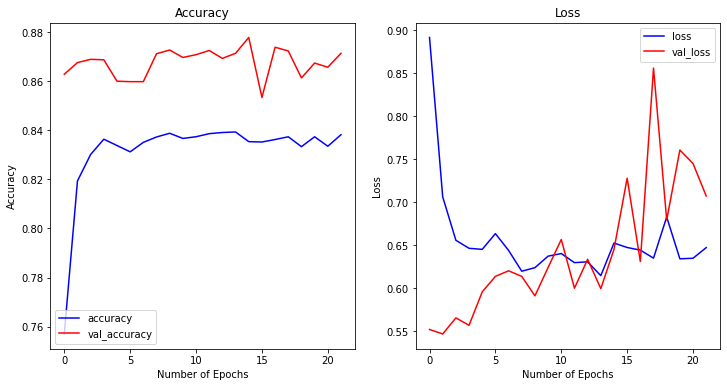

In [ ]:
plot_history(history_5)

In [77]:
model_classification_report(model_5, X_train, y_train)

1484/1484 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     16773
           1       1.00      1.00      1.00      9264
           2       0.88      0.99      0.93      2743
           3       0.94      0.83      0.88      4151
           4       0.97      0.99      0.98      5375
           5       0.97      0.97      0.97      2564
           6       1.00      1.00      1.00      1946
           7       1.00      1.00      1.00       872
           8       0.99      0.96      0.98       612
           9       1.00      0.97      0.98        29
          10       0.96      0.95      0.96       310
          11       0.99      0.95      0.97       831
          12       1.00      0.91      0.95        46
          13       0.99      0.94      0.97       161
          14       1.00      1.00      1.00       408
          15       1.00      1.00      1.00        19
          16       1.00 

## 8. Evaluation

In [117]:
presumably_best_model = model_5

In [118]:
# Take the best performing model and evaluate it on the test set
# In our case model number 5 shows the best performance.
# Therefore we evaluated it on the test set.
model_classification_report(presumably_best_model, X_test, y_test)

413/413 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      4652
           1       0.99      0.99      0.99      2590
           2       0.82      0.90      0.85       774
           3       0.73      0.67      0.70      1147
           4       0.90      0.94      0.92      1453
           5       0.90      0.87      0.88       715
           6       0.99      0.99      0.99       551
           7       0.95      0.99      0.97       250
           8       0.94      0.78      0.85       165
           9       1.00      1.00      1.00         9
          10       0.84      0.65      0.73        72
          11       0.93      0.79      0.86       237
          12       0.86      0.67      0.75        18
          13       0.92      0.53      0.68        43
          14       0.96      0.99      0.98       110
          15       0.00      0.00      0.00         5
          16       1.00   

In [121]:
y_test_idx = y_test.argmax(axis=1)
y_pred_idx = presumably_best_model.predict(X_test, verbose=1).argmax(axis=1)
#def model_classification_report(model, X_train, y_train):
#  y_pred = model.predict(X_train, verbose=1)
#  print(classification_report(y_train.argmax(axis=1), y_pred.argmax(axis=1)))

print(confusion_matrix(y_test_idx, y_pred_idx))

413/413 [==============================] - 1s 1ms/step
[[4470    5   20 ...    0    0    0]
 [   1 2575    0 ...    0    0    0]
 [  19    0  693 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    1    0]
 [   0    0    0 ...    0    0    0]]


### Confusion Matrix

In [ ]:
label_dict = pd.Series(df_test.label.values,index=df_test.label_index).to_dict()

test_list = test_classes_categorical.argmax(axis=1)
predicted_list = predicted_list.argmax(axis=1)
test_list_label = [label_dict[x] for x in test_list]
predicted_list_label = [label_dict[x] for x in predicted_list]

In [ ]:
confusion_matrix_final = confusion_matrix(test_list_label, predicted_list_label)

In [ ]:
confusion_matrix_dataframe = pd.DataFrame(confusion_matrix_final)
confusion_matrix_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,528,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,42,0,2,0,2,0,0,0,0,...,0,2,0,0,0,0,0,0,0,2
2,0,0,9,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,4616,15,11,0,13,3,3,...,0,5,0,1,1,0,1,0,0,88
4,0,0,0,15,1403,11,0,3,4,0,...,0,0,0,8,0,0,0,0,1,31


In [ ]:
confusion_matrix_dataframe.reset_index(inplace=True)
confusion_matrix_dataframe.head()

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,0,528,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,42,0,2,0,2,0,0,0,...,0,2,0,0,0,0,0,0,0,2
2,2,0,0,9,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,0,0,0,4616,15,11,0,13,3,...,0,5,0,1,1,0,1,0,0,88
4,4,0,0,0,15,1403,11,0,3,4,...,0,0,0,8,0,0,0,0,1,31


In [ ]:
confusion_matrix_dataframe= confusion_matrix_dataframe.replace({"index": label_dict})
confusion_matrix_dataframe = confusion_matrix_dataframe.set_index('index')

In [ ]:
confusion_matrix_dataframe.columns = [label_dict[x] for x in confusion_matrix_dataframe.columns]

In [ ]:
confusion_matrix_dataframe

,ar,de,el,en,es,fr,he,id,it,ja,...,ms,nl,pl,pt,ru,sv,th,tl,tr,und
index,,,,,,,,,,,,,,,,,,,,,
ar,528,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
de,0,42,0,2,0,2,0,0,0,0,...,0,2,0,0,0,0,0,0,0,2
el,0,0,9,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
en,0,0,0,4616,15,11,0,13,3,3,...,0,5,0,1,1,0,1,0,0,88
es,0,0,0,15,1403,11,0,3,4,0,...,0,0,0,8,0,0,0,0,1,31
fr,0,0,0,14,5,196,0,1,0,0,...,0,2,0,0,0,0,0,0,0,6
he,0,0,0,0,0,0,13,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id,0,0,0,24,2,4,0,730,0,1,...,7,2,0,1,0,0,1,5,0,39
it,0,0,0,2,6,1,0,0,63,0,...,0,0,0,1,0,0,0,0,0,3


### Heatmap for Confusion matrix

In [ ]:
import seaborn as sn

In [116]:
plt.figure(figsize = (10, 10))
sn.set(font_scale=2) 
sn.heatmap(confusion_matrix_dataframe, annot=True, annot_kws={"size": 20}, fmt='.4g')

NameError: ignored

<Figure size 720x720 with 0 Axes>